In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from Unet_model import Unet_model
from validation import eval_net_loader
# from utils import mask2rgb
from sklearn.metrics import confusion_matrix

from PIL import Image
import numpy as np

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import listdir, makedirs
from os.path import isfile, join, exists

In [1]:
# utils
from os import listdir
from os.path import isfile, join
path ='./data_512_128/train/'
dataset = set([f for f in listdir(path+'images/') if isfile(join(path+'images/', f)) and ".png" in f])
maskset = set([f for f in listdir(path+'masks/') if isfile(join(path+'masks/', f)) and ".png" in f])

removeset1 = dataset - maskset
print(len(removeset1))
removeset2 = maskset - dataset
print(len(removeset2))
# from os import remove
# for file in removeset:
#   remove(path+'images/'+file)

#   removeset = dataset - maskset
# print(removeset)

FileNotFoundError: [Errno 2] No such file or directory: './data_512_128/train/images/'

In [7]:
from os import listdir
from os.path import isfile, join
from random import shuffle
path ='./data_512_128/train/'

dataset = [f for f in listdir(path+'images/') if isfile(join(path+'images/', f)) and ".png" in f]
shuffle(dataset)
k = len(dataset)//2

moveset = dataset[k:]

from shutil import copy
from os import remove
# for file in moveset:
#     copy(path+'images/'+file,path+'images_part1')
#     remove(path+'images/'+file)
#     copy(path+'masks/'+file,path+'masks_part1')
#     remove(path+'masks/'+file)

# Create predicted directory

In [4]:
for i in range(1,20):
    if not exists(f'predict/predict_{i}'):
        makedirs(f'predict/predict_{i}')

# predict

In [6]:
palletes = {
    0: [0,0,0],
    1: [255,0,0],
    2: [255,255,0],
    3: [255,0,255],
    4: [0,255,0],
    5: [0,255,255]
}

def mask2rgb(mask):
    rgb = np.zeros(mask.shape+(3,), dtype=np.uint8)
    for i in np.unique(mask):
            rgb[mask==i] = palletes[i]
    return rgb

class GetData(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.data_files = listdir(data_path)

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, index):
        image = Image.open(self.data_path + '/' + self.data_files[index])
        image = np.array(image)/255
        sample = {
            'image': torch.from_numpy(image).permute(2,0,1).float(),
            'name': self.data_files[index]
        }

        return sample
    
dataset = GetData('./predict/images')
loader = DataLoader(dataset, batch_size = 2, num_workers = 2, drop_last=True)

for fi in range(17,20):
    trained_model = f'./cp_unet_512_v4_weighted/CP{fi}.pth'
    net = Unet_model(in_channels=3 ,n_classes=6)
    net.load_state_dict(torch.load(trained_model))
    net.eval()

    for batch in tqdm(loader):
        outputs = net(batch['image'])
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i,name in enumerate(batch['name']):
            rgb = mask2rgb(preds[i])
            rgb = Image.fromarray(rgb, 'RGB')
            rgb.save(f'./predict/predict_{fi}/{name}')

100%|████████████████████████████████████████| 388/388 [20:18<00:00,  3.14s/it]


In [3]:
Image.MAX_IMAGE_PIXELS = None
stride_pixel = 512
image_size = 512
for fi in range(15,21):
    print(f'Working on folder {fi} ...')
    predict_path = f'./predict/predict_{fi}'
    predict_files = listdir(predict_path)
    paste_field = Image.new(mode="RGB", size=(25088,23040))
    for piece in tqdm(predict_files):
        c,r = piece.replace('.png','').split('-')
        c,r = int(c), int(r)
        piece = Image.open(predict_path+'/'+piece)
        paste_field.paste(piece,(c*stride_pixel,r*stride_pixel))

    print('Writing result ...')
    paste_field.save(f'./predict/result_{fi}.png')
    print('Done!')

Working on folder 15 ...


100%|████████████████████████████████████████| 776/776 [00:02<00:00, 351.77it/s]


Writing result ...
Done!
Working on folder 16 ...


100%|████████████████████████████████████████| 776/776 [00:02<00:00, 367.33it/s]


Writing result ...
Done!
Working on folder 17 ...


100%|████████████████████████████████████████| 776/776 [00:02<00:00, 336.96it/s]


Writing result ...
Done!
Working on folder 18 ...


100%|████████████████████████████████████████| 776/776 [00:02<00:00, 337.46it/s]


Writing result ...
Done!
Working on folder 19 ...


100%|████████████████████████████████████████| 776/776 [00:02<00:00, 324.96it/s]


Writing result ...
Done!
Working on folder 20 ...


100%|████████████████████████████████████████| 776/776 [00:02<00:00, 282.85it/s]


Writing result ...
Done!


# calculate confusion matrix

In [5]:
dataset = MyDataset('./data/val', transform = None)
loader = DataLoader(dataset, batch_size = 2, num_workers = 2, drop_last=True)

In [6]:
def compute_IoU(cm):

    sum_over_row = cm.sum(axis=0)
    sum_over_col = cm.sum(axis=1)
    true_positives = np.diag(cm)

    denominator = sum_over_row + sum_over_col - true_positives
    
    iou = true_positives / denominator
    
    return iou, np.nanmean(iou)


def eval_net_loader(net, val_loader, n_classes, device = 'cpu'):
    net.eval()
    labels = np.arange(n_classes)
    cm = np.zeros((n_classes,n_classes))

    for i, batch in enumerate(tqdm(val_loader)):
        imgs = batch['image'].to(device)
        masks = batch['mask'].to(device)
        
        outputs = net(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for j in range(len(masks)):
            true = masks[j].cpu().detach().numpy().flatten()
            pred = preds[j].cpu().detach().numpy().flatten()
            cm += confusion_matrix(true, pred, labels=labels)

    class_iou, mean_iou = compute_IoU(cm)
    return cm, class_iou, mean_iou

100%|█████████████████████████████████████████| 138/138 [06:36<00:00,  2.88s/it]


<AxesSubplot:>

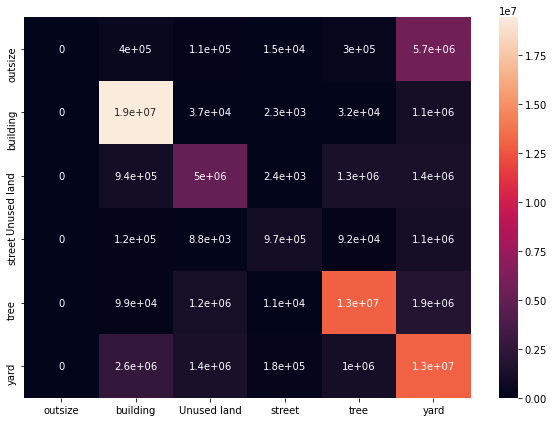

In [8]:
cm, class_iou, mean_iou = eval_net_loader(net, loader, 6, device = 'cpu')
labels = ['outsize','building','Unused land','street','tree','yard']
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)